# Loan Approval Prediction

### Author: Michael Wu

### Date: Dec.14/2023

In [10]:
knitr::opts_chunk$set(echo = FALSE)
library(readr)
library(ggplot2)
library(dplyr)
library(tidyverse)
urlPackage <- "https://cran.r-project.org/src/contrib/Archive/randomForest/randomForest_4.6-14.tar.gz"
install.packages(urlPackage, repos=NULL, type="source") 
library(randomForest)

Installing package into ‘/opt/r’
(as ‘lib’ is unspecified)



## Introduction

How likely is it that your home loan application gets approved? What factors determine this likelihood? Is it your income? marital status? credit history? or other factors. In this project, we want to discover what kind of factors can most affect the loan approval. We will also be using the machine-learning algorithm, random forest to build a model which can predict whether or not a loan application is approved given the applicant's background, such as gender, credit history, number of dependents, income, and so on. 

In [11]:
train <- read_csv("~/loan approval/loan_sanction_train.csv")

train$Gender <- as.factor(train$Gender)
train$Married <- as.factor(train$Married)
train$Education <- as.factor(train$Education)
train$Self_Employed <- as.factor(train$Self_Employed)
train$Property_Area <- as.factor(train$Property_Area)
train$Dependents <- as.factor(train$Dependents)
train$Loan_Status <- as.factor(train$Loan_Status)
train$total_income <- train$ApplicantIncome + train$CoapplicantIncome
train$income_to_loan_ratio <- train$total_income/train$LoanAmount
train$Credit_History <- as.factor(train$Credit_History)

# remove ID column

train <- subset(train, select = -c(Loan_ID))

# EDA

train_imputed <- rfImpute(Loan_Status ~ ., data = train, iter = 6)

for_bar_charts <- train_imputed %>%
  select(Gender, Married, Dependents, Education, Self_Employed, Credit_History, Property_Area, Loan_Status)

for_hist <- train_imputed %>%
  select(ApplicantIncome, CoapplicantIncome, total_income, LoanAmount, Loan_Amount_Term, income_to_loan_ratio, Loan_Status)


Rows: 614 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ntree      OOB      1      2
  300:  19.54% 48.44%  6.40%
ntree      OOB      1      2
  300:  18.57% 46.88%  5.69%
ntree      OOB      1      2
  300:  18.73% 45.83%  6.40%
ntree      OOB      1      2
  300:  19.22% 48.44%  5.92%
ntree      OOB      1      2
  300:  19.06% 48.44%  5.69%
ntree      OOB      1      2
  300:  18.57% 46.88%  5.69%


# EDA

## Variables

- Loan Status: Whether or not the loan is approved.
- Gender: Gender of Applicant.
- Marital Status: Whether the applicant is married or not.
- Dependents: Number of dependents(Children) the applicant has.
- Educated: Whether the applicant has graduated college.
- Self-employed: Whether the applicant is self-employed.
- Credit: Applicant's credit history, 1 indicating applicant has good credit score, 0 otherwise.
- Property Area: The type of area the applicant lives in: Urban, Suburban, Rural.
- Applicant Income: Applicant's income per period.
- Co-applicant Income: The co-applicant's income per period.
- Total Income: Combined income per period between the applicant and co-applicant.
- Loan Amount: The amount of loan requested.
- Loan term: The length of the loan in months.
- Income-to-loan Ratio: The ratio between total income and loan amount.

## Data

NA values are imputed using random forest. Income-to-loan ratio is produced by dividing total income by loan amount.

## Distribution of Categorical Variables

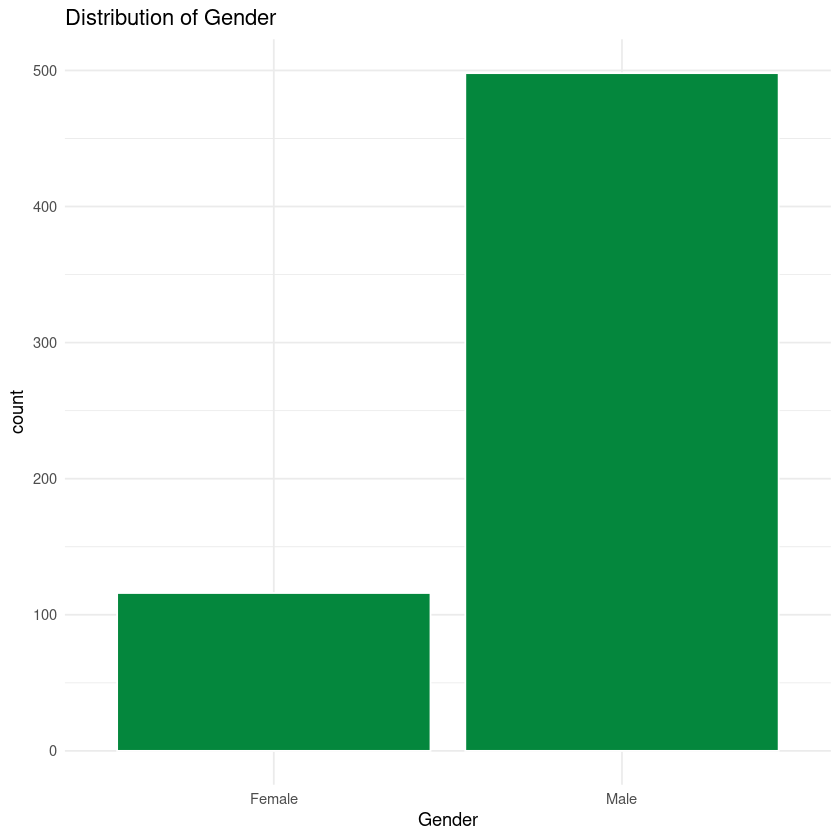

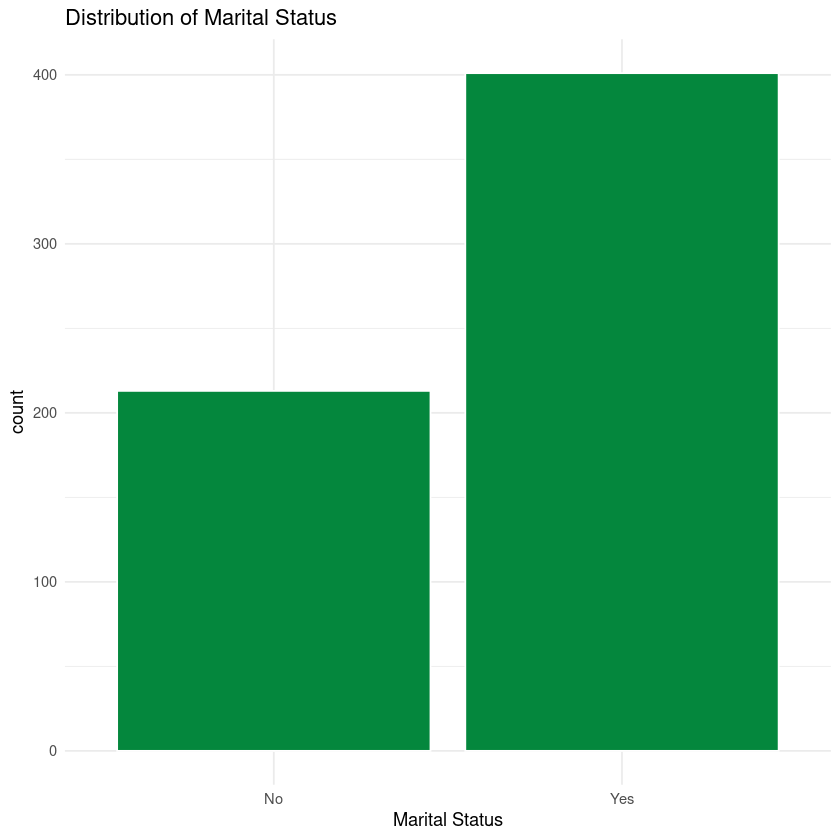

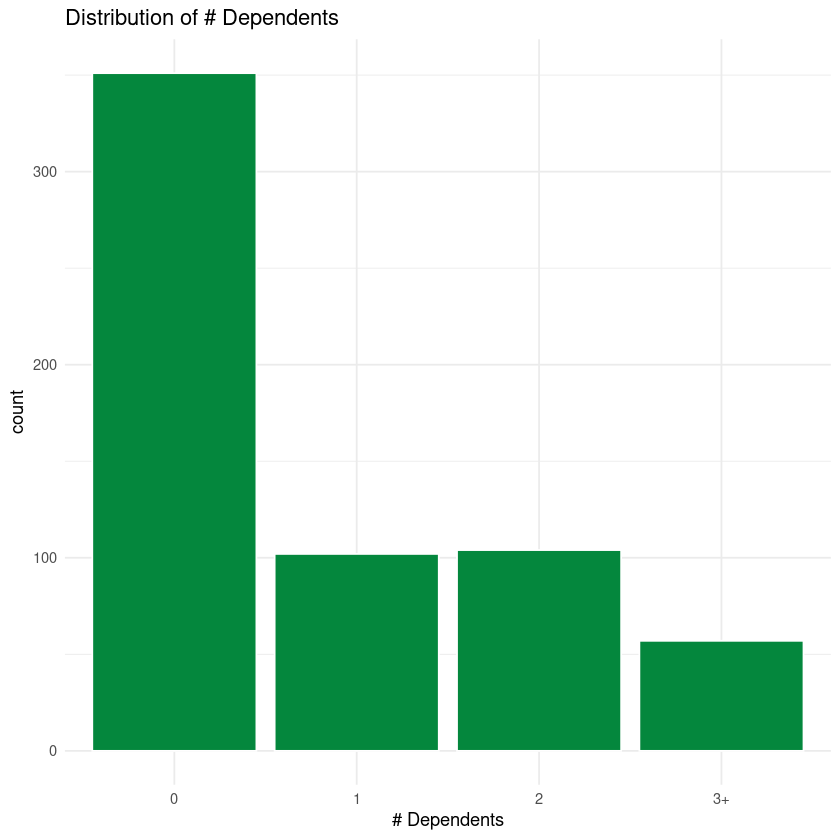

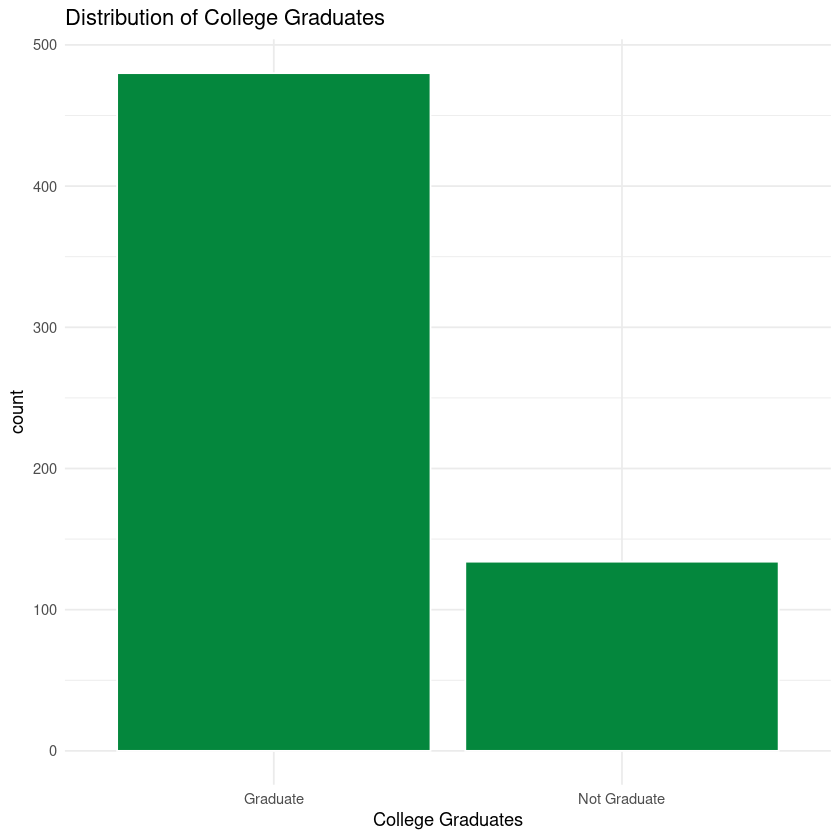

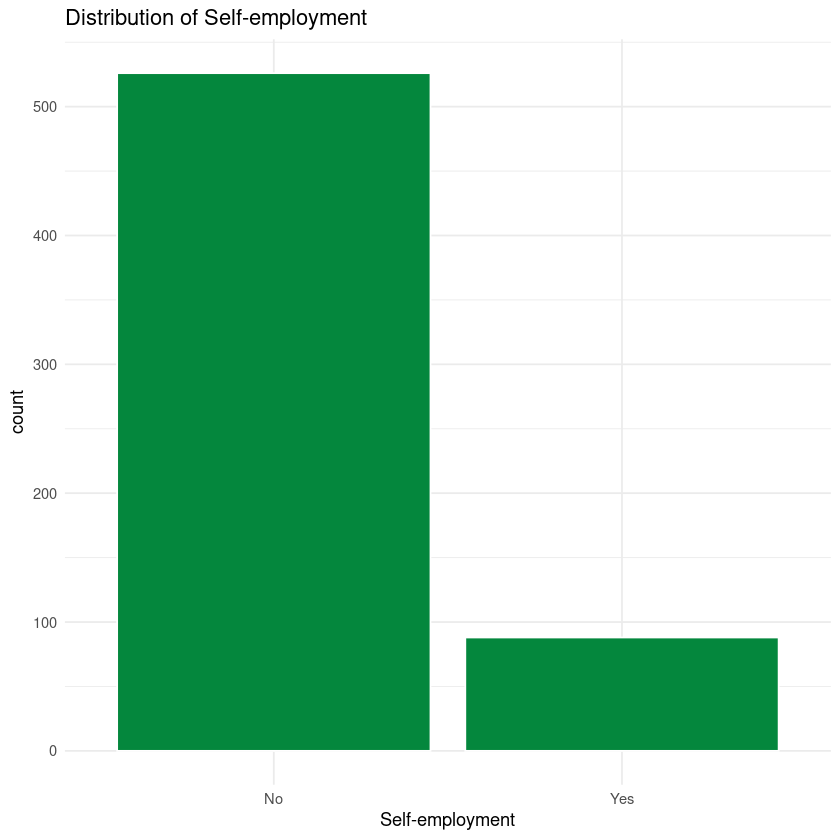

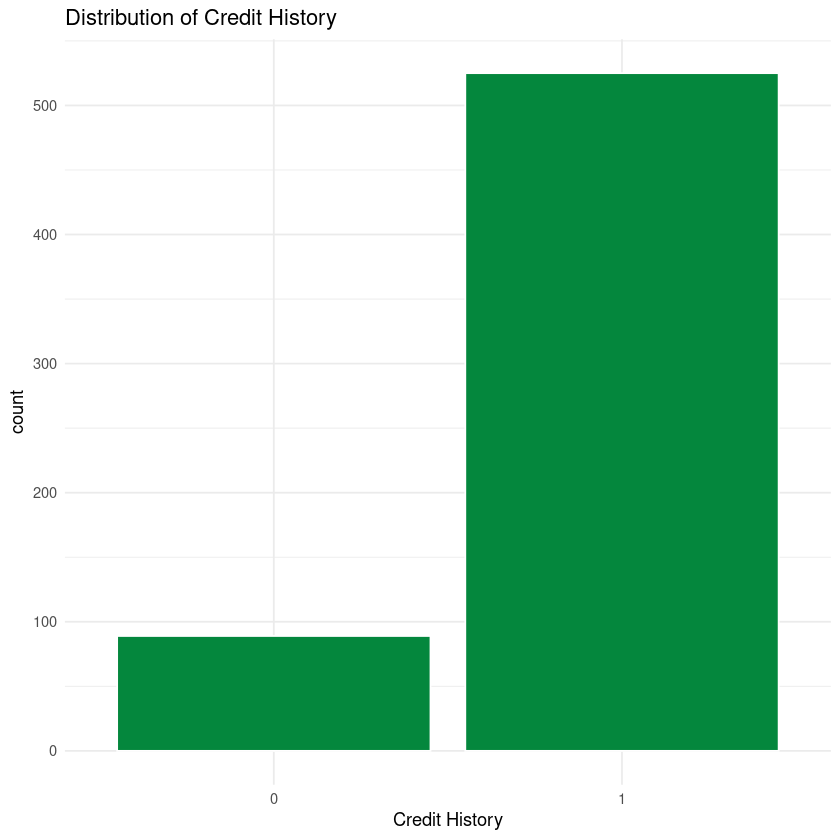

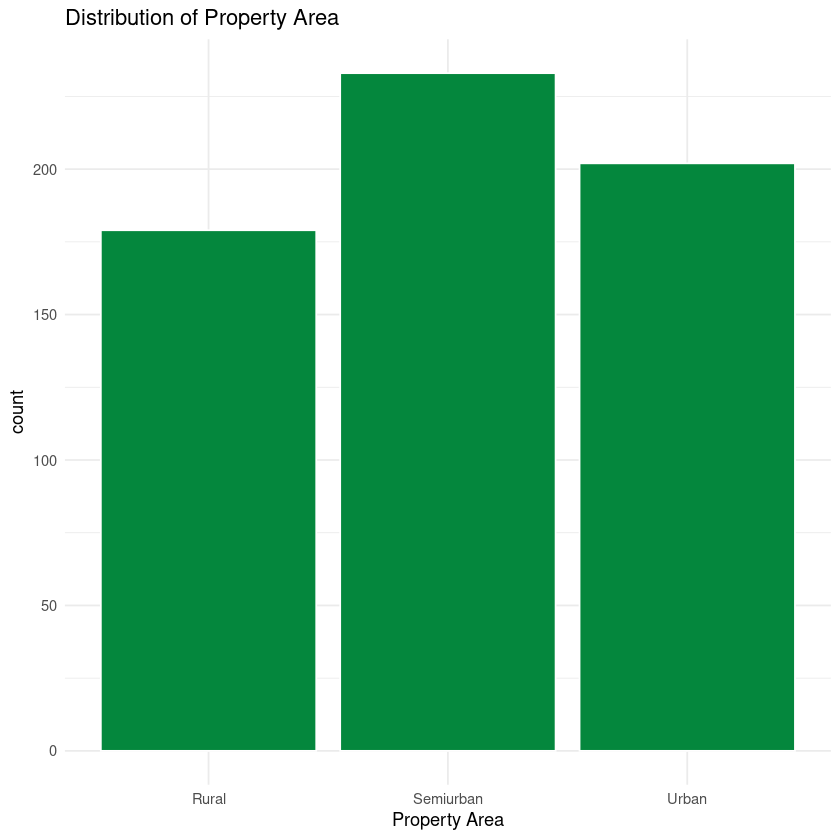

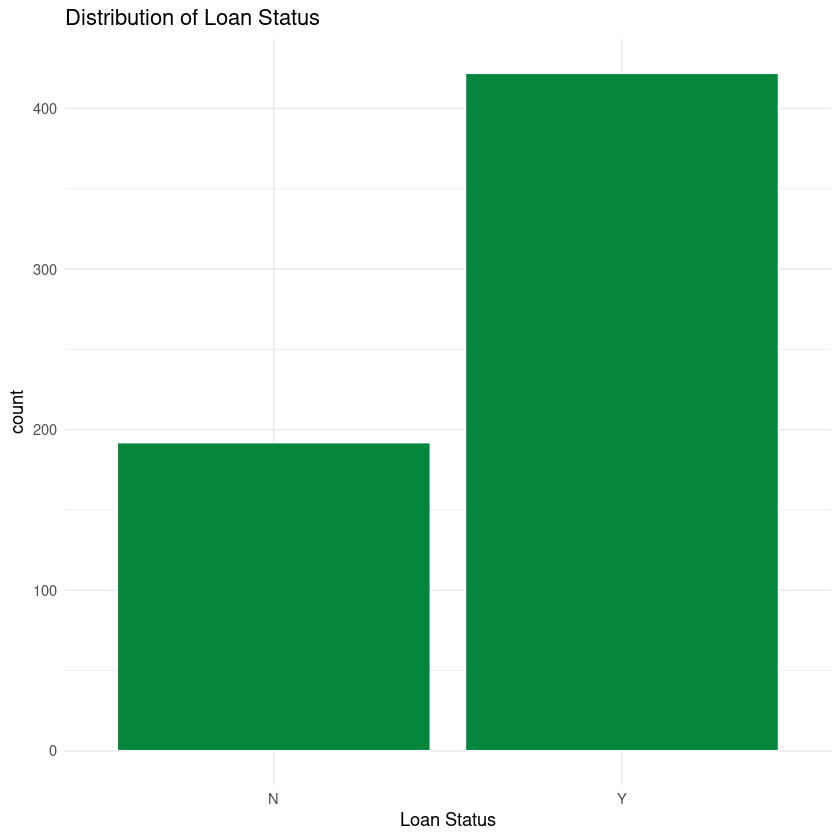

In [3]:
colnames(for_bar_charts) <- c('Gender', 'Marital Status', '# Dependents',
                              'College Graduates', 'Self-employment', 
                              'Credit History', 'Property Area', 'Loan Status')

for (column in colnames(for_bar_charts)) {
  # Create a ggplot object for each variable
  plot <- ggplot(for_bar_charts, aes(x = .data[[column]])) +
    geom_bar(fill = '#04873d', color = 'white') +
    labs(title = paste("Distribution of", column)) +
    theme_minimal()
  
  # Display the plot
  print(plot)
}

Observation: 

- Most applicants are male, married, have 0 dependents, college graduates, not self-employed, have good credit history.
- About 2/3 of loan applications are approved. 

# Distribution of Continuous Variables


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


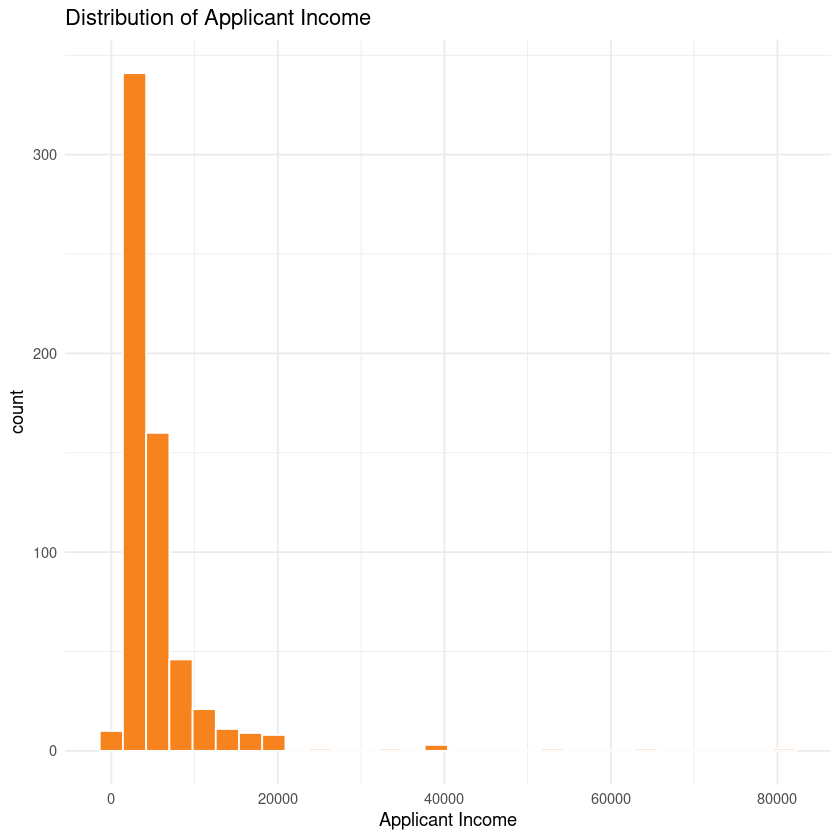

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


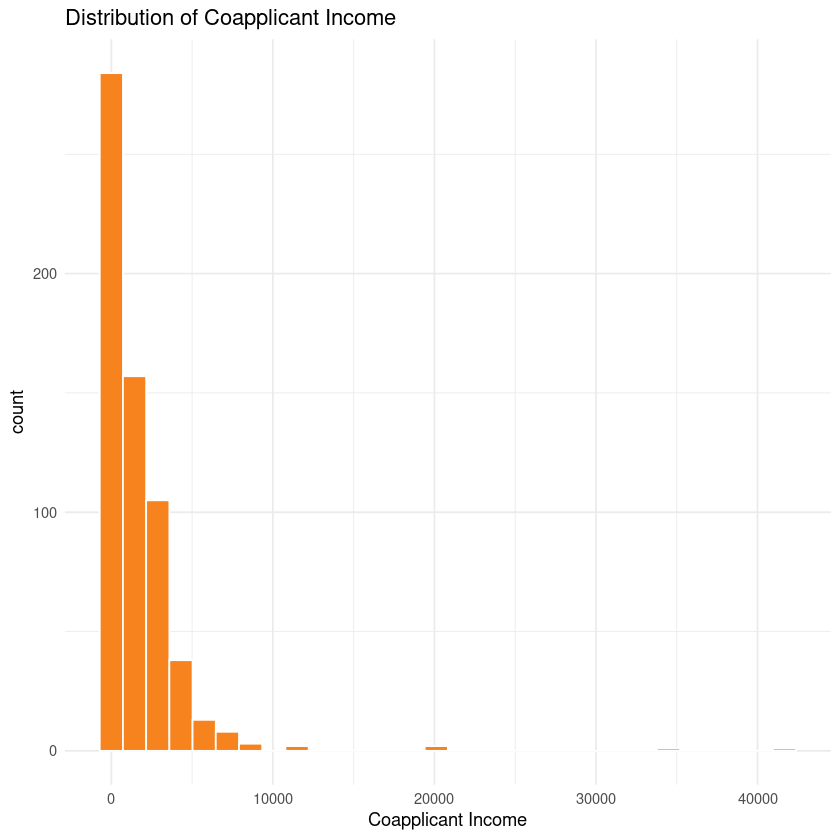

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


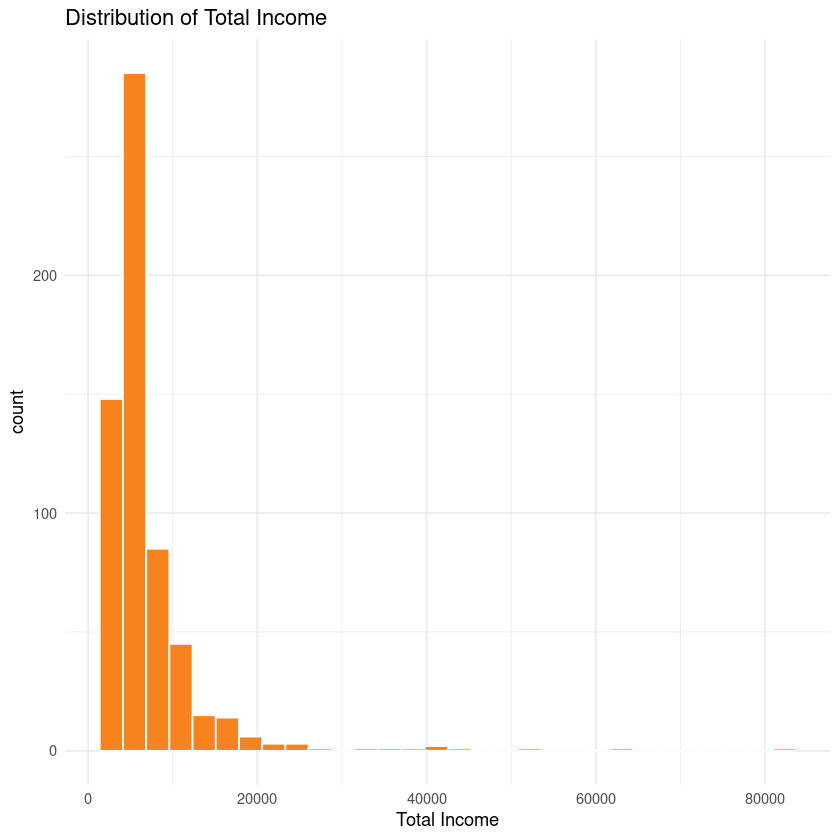

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


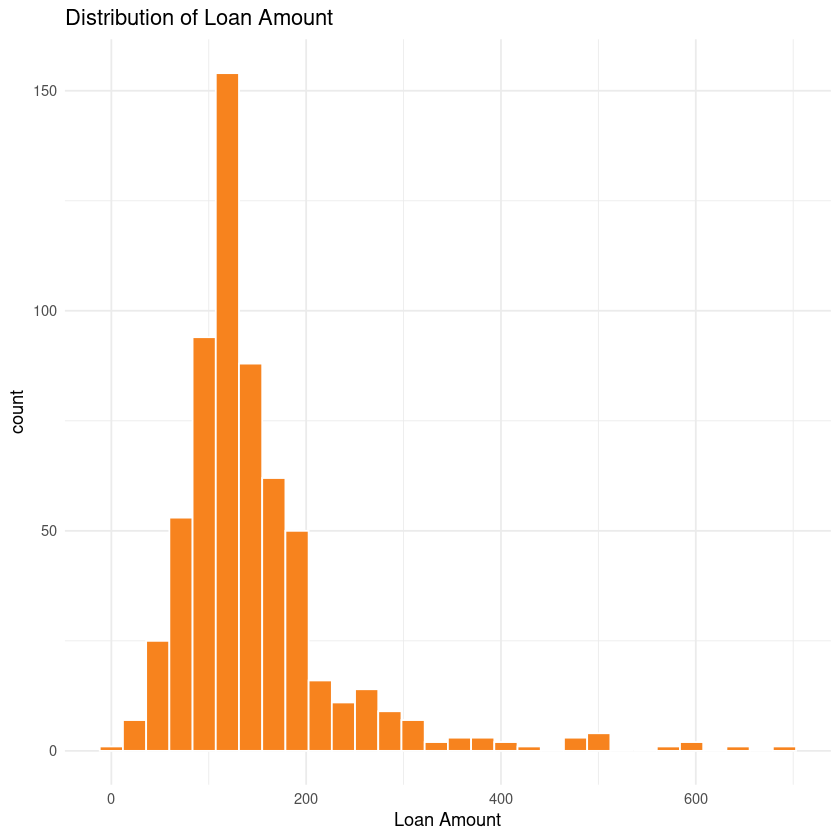

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


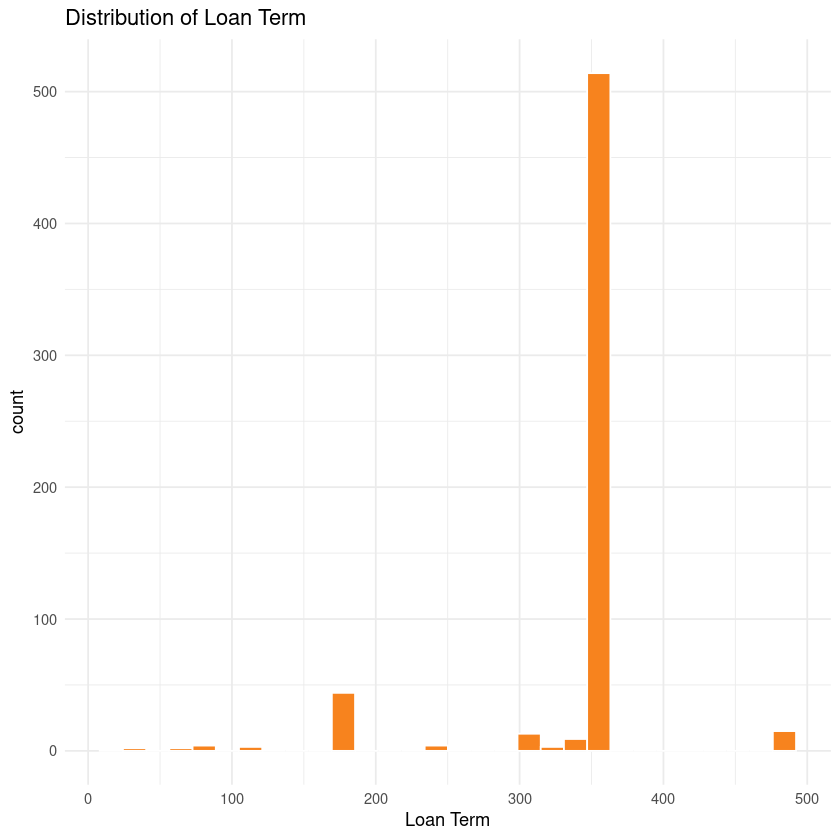

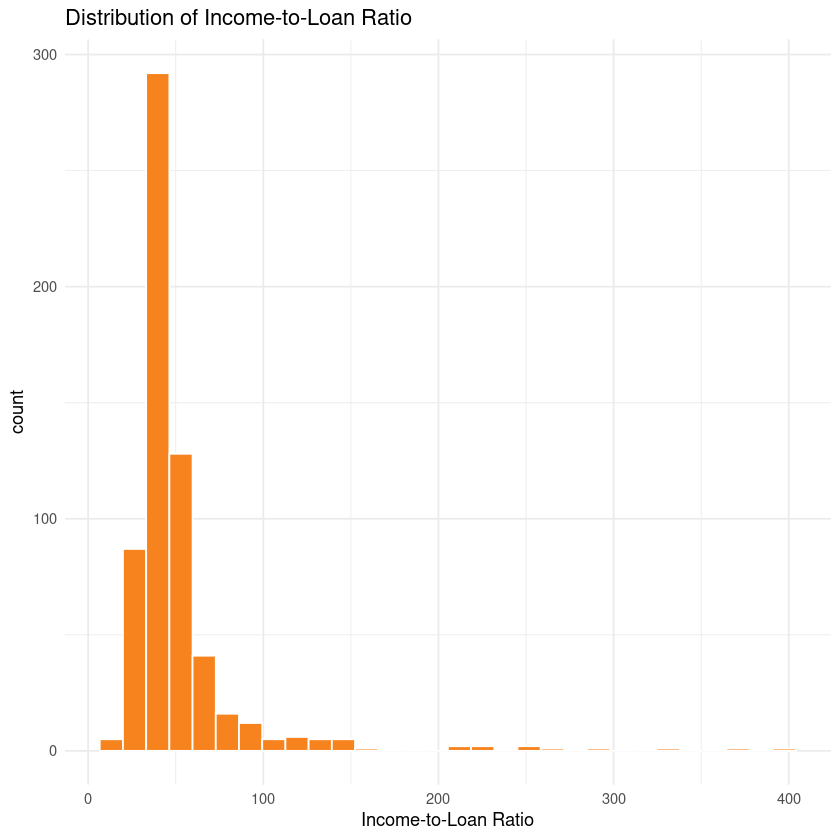

In [4]:

colnames(for_hist) <- c('Applicant Income', 'Coapplicant Income','Total Income',
                        'Loan Amount', 'Loan Term','Income-to-Loan Ratio', 'Loan Status')

for (column in colnames(for_hist[1:6])) {
  # Create a ggplot object for each variable
  plot <- ggplot(for_hist, aes(x = .data[[column]])) +
    geom_histogram(color = 'white', fill = '#f7831e') +
    labs(title = paste("Distribution of", column)) +
    theme_minimal()
  
  # Display the plot
  print(plot)
}

Observation: 

- Most of the loan terms are around 360 months in length. 
- All income variables are right skewed as expected as observed in the real world.
- Loan amount and Income-to-loan Ratio are normally distributed but still right skewed.


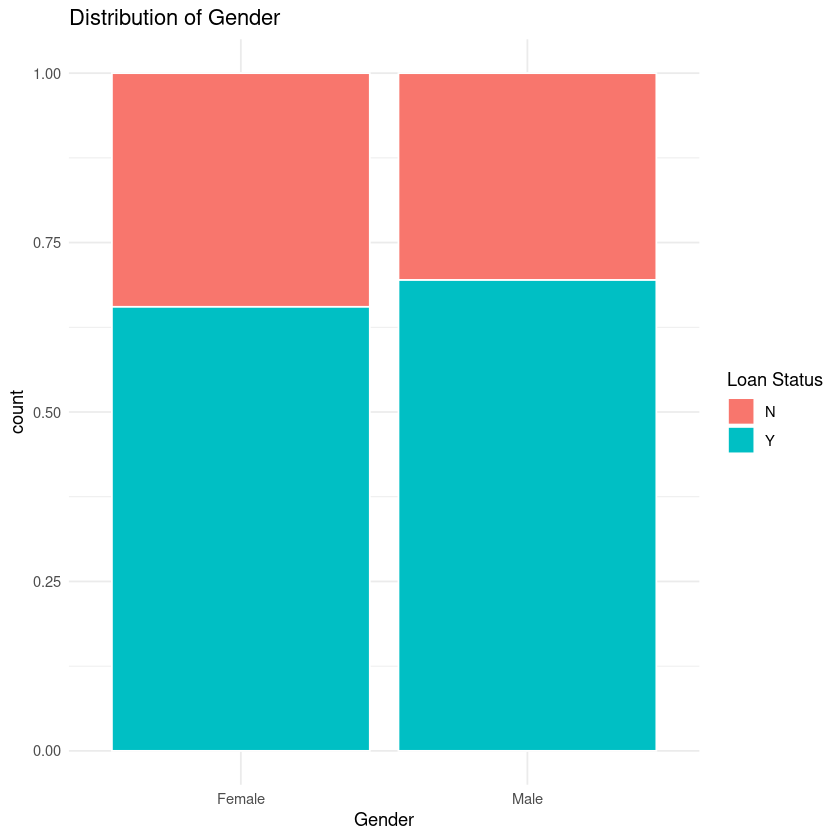

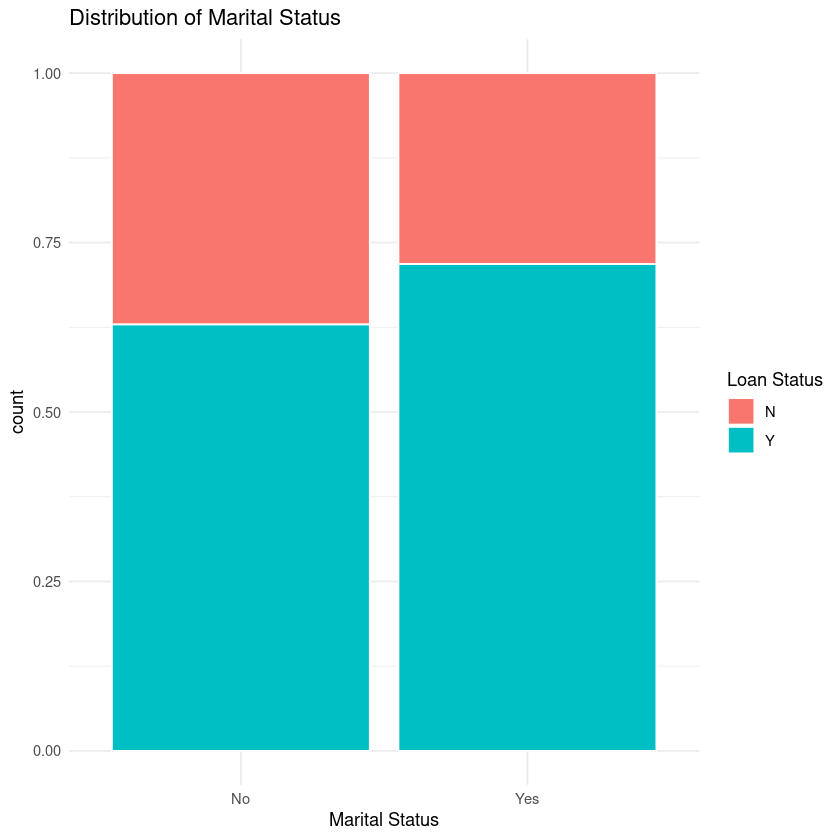

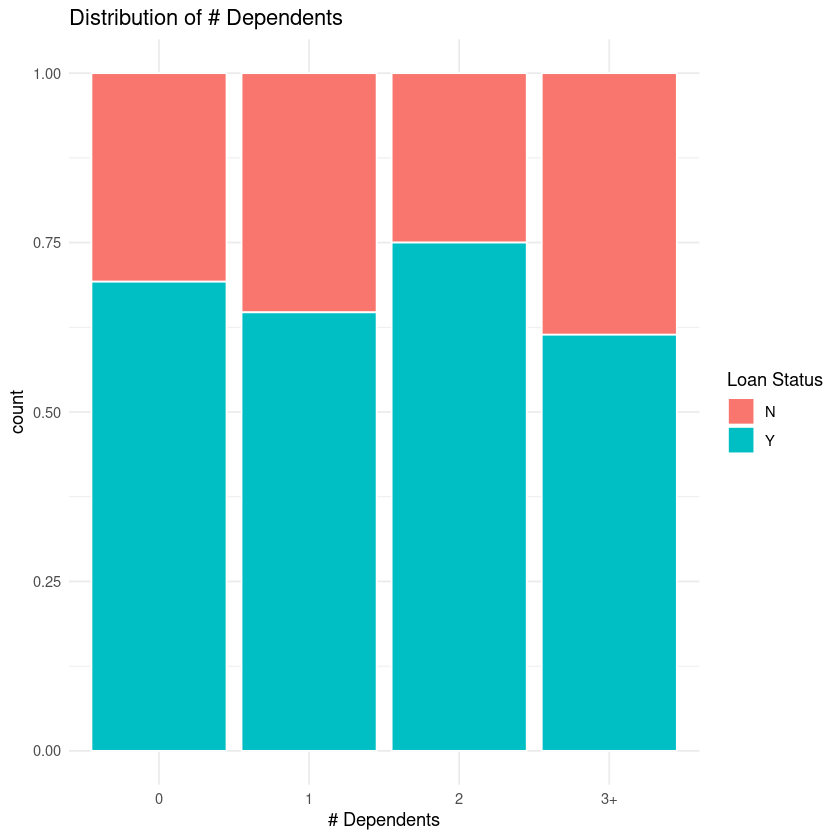

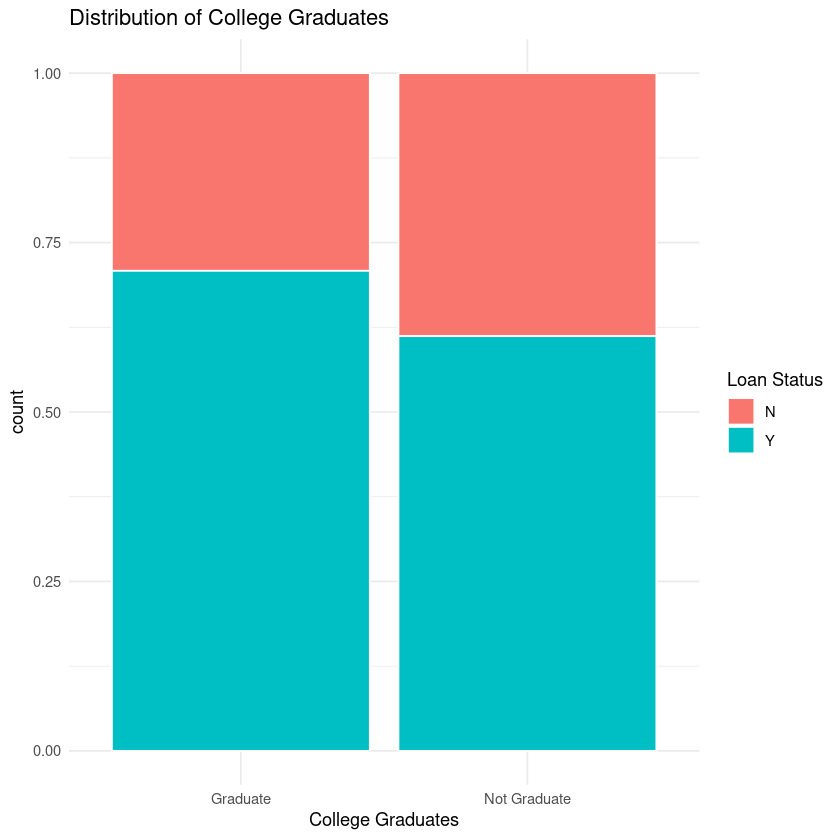

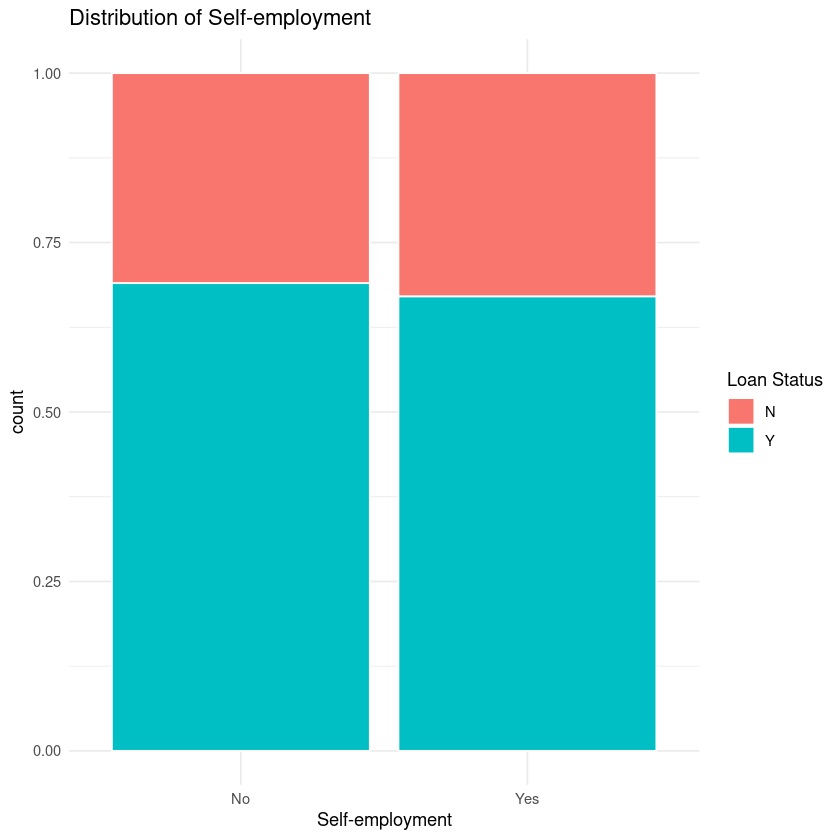

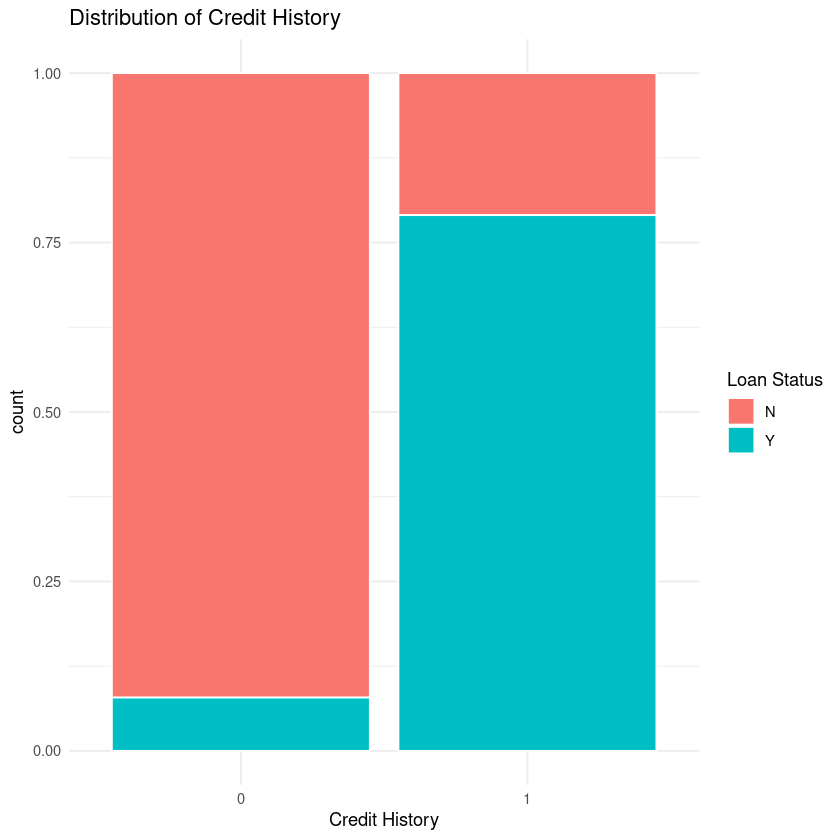

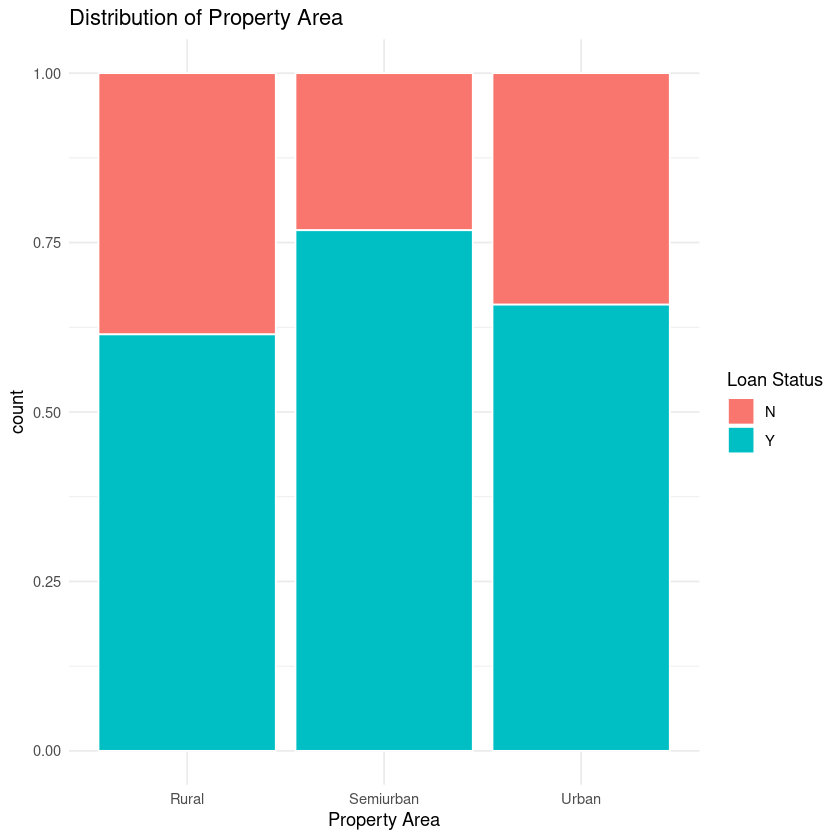

In [5]:
for (column in colnames(for_bar_charts[1:7])) {
  # Create a ggplot object for each variable
  plot <- ggplot(for_bar_charts, aes(fill = `Loan Status`, x = .data[[column]]), y = Value) +
    geom_bar(position="fill", color = 'white') +
    labs(title = paste("Distribution of", column)) +
    theme_minimal()
  
  # Display the plot
  print(plot)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


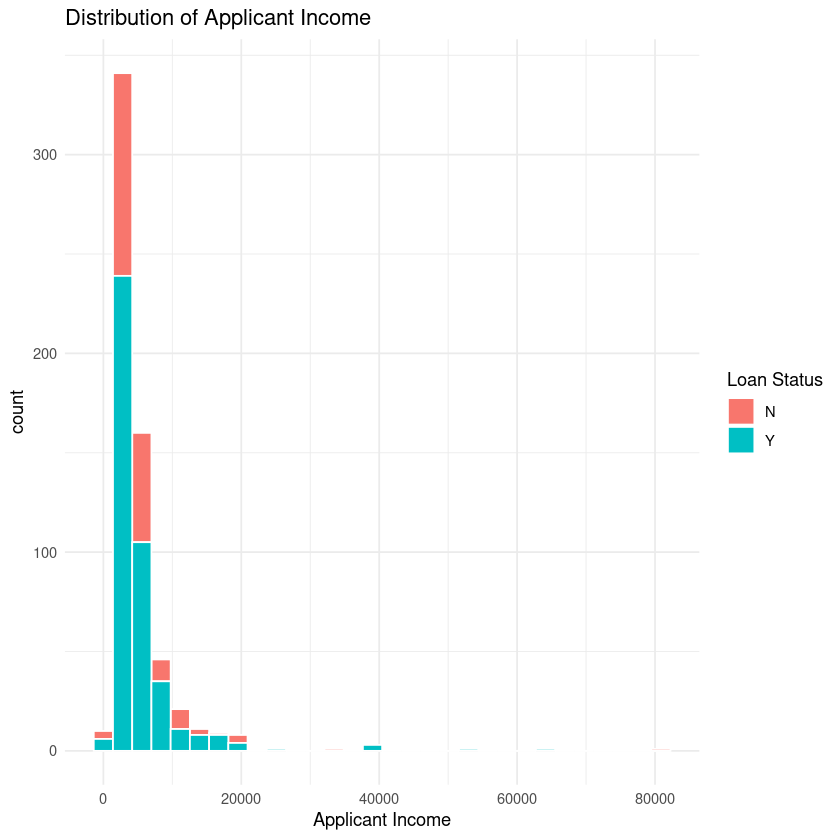

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


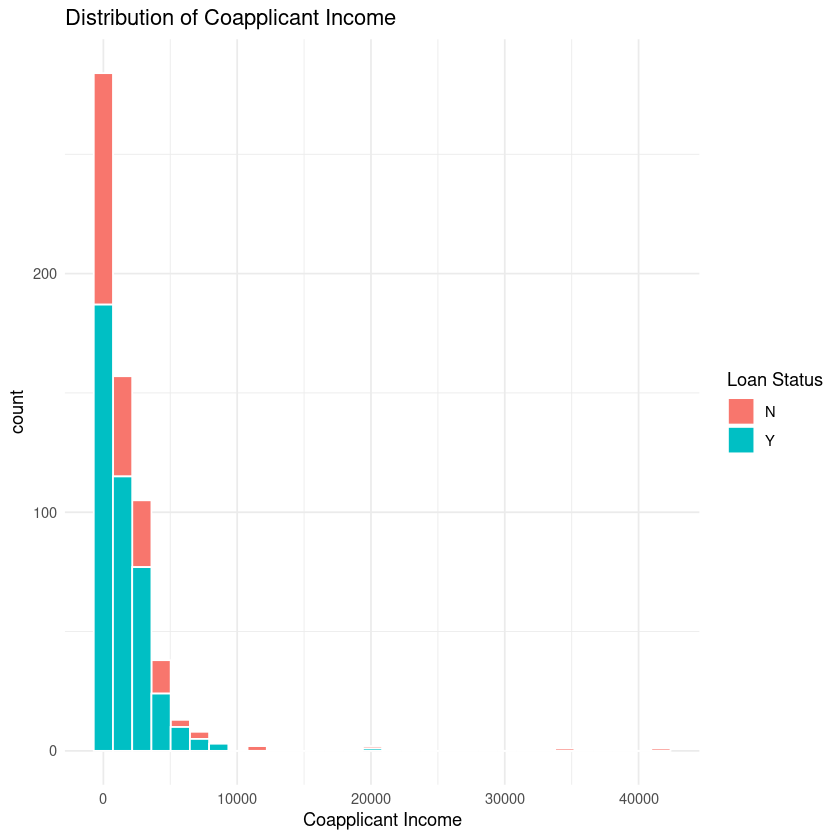

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


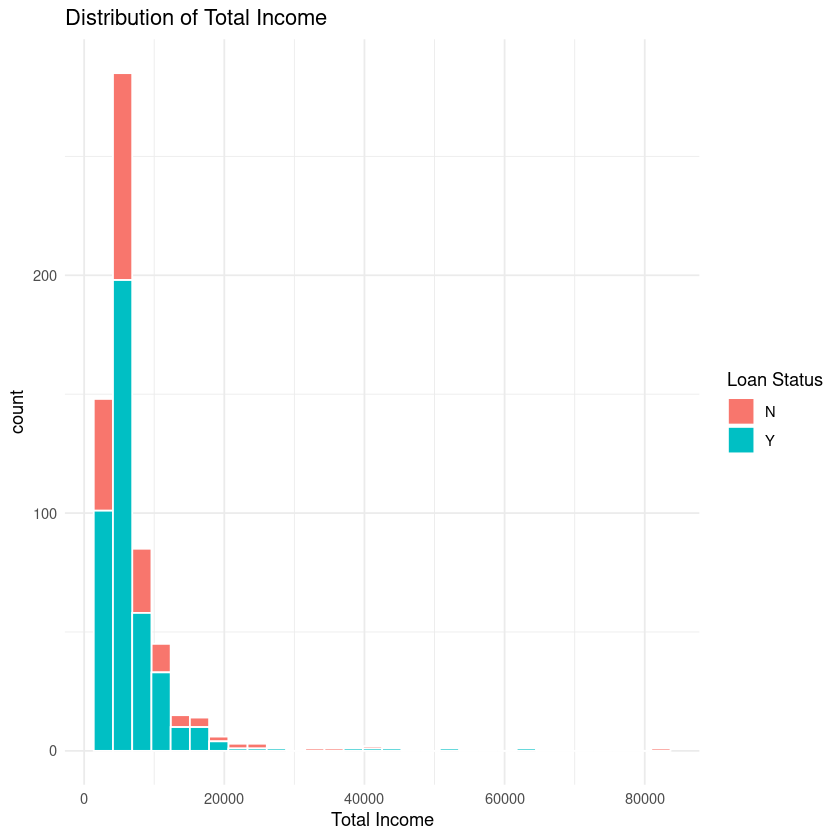

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


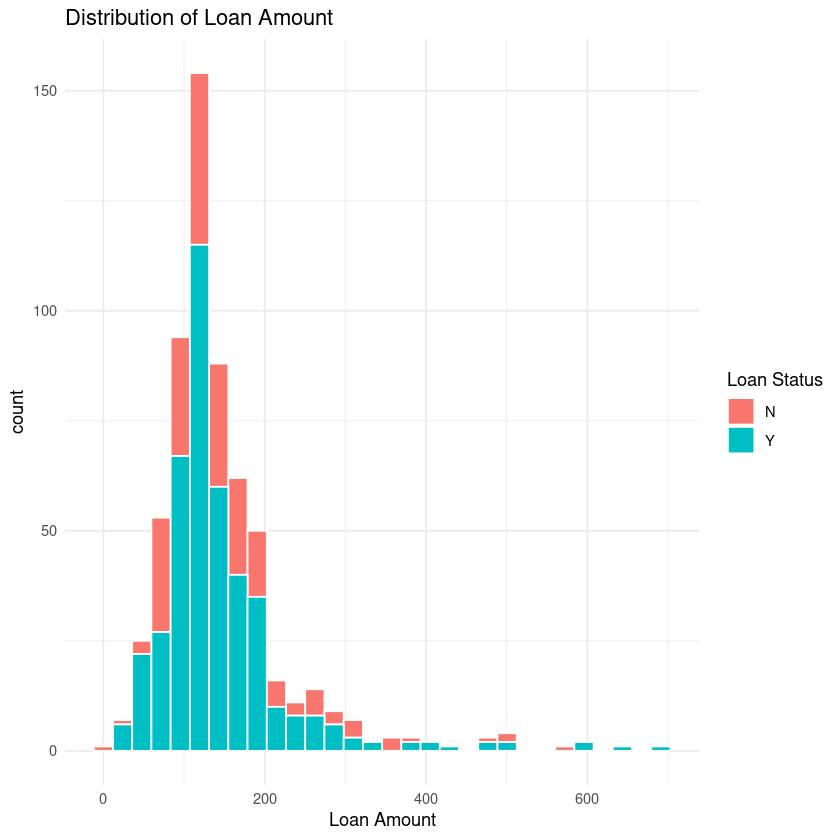

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


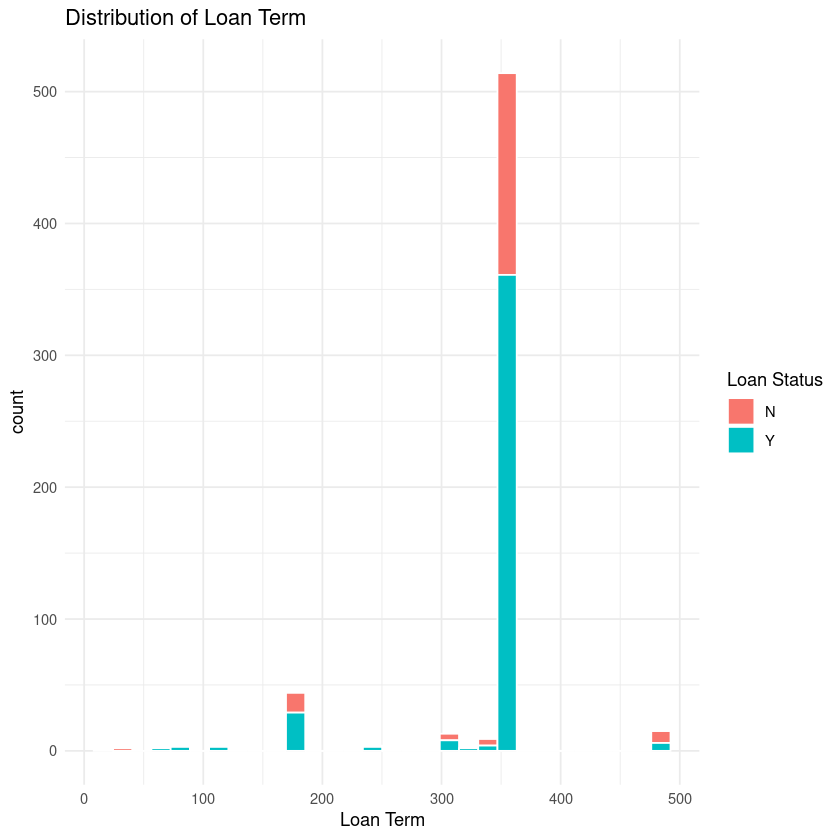

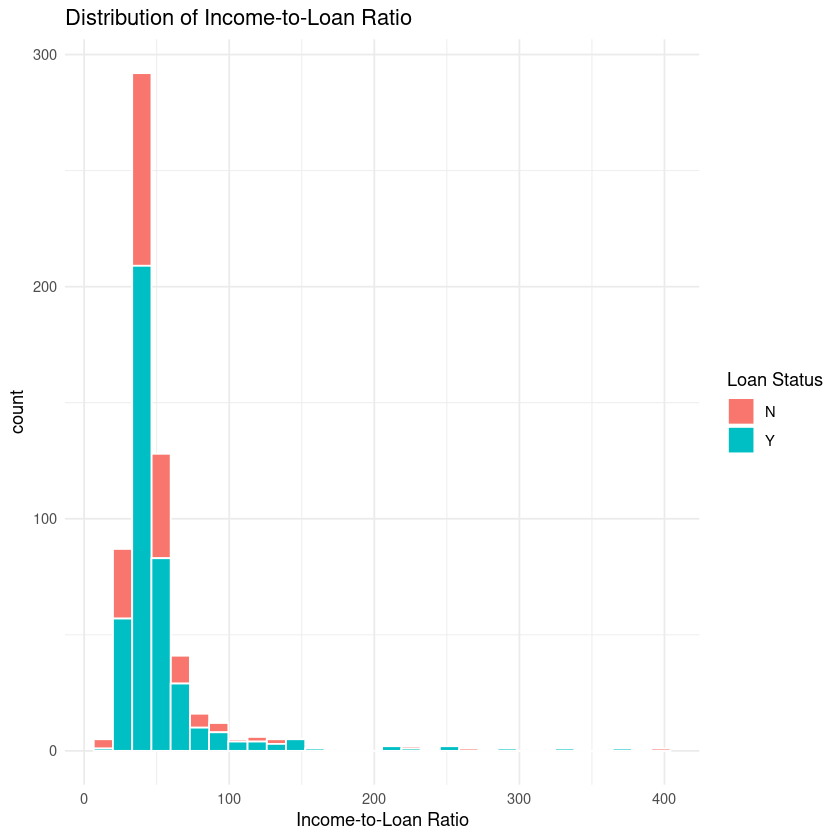

In [6]:
for (column in colnames(for_hist[1:6])) {
  # Create a ggplot object for each variable
  plot <- ggplot(for_hist, aes(x = .data[[column]], fill = `Loan Status`)) +
    geom_histogram(color = 'white') +
    labs(title = paste("Distribution of", column)) +
    theme_minimal()
  
  # Display the plot
  print(plot)
}

Warning message:
“Removed 18 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 33 rows containing non-finite values (`stat_boxplot()`).”


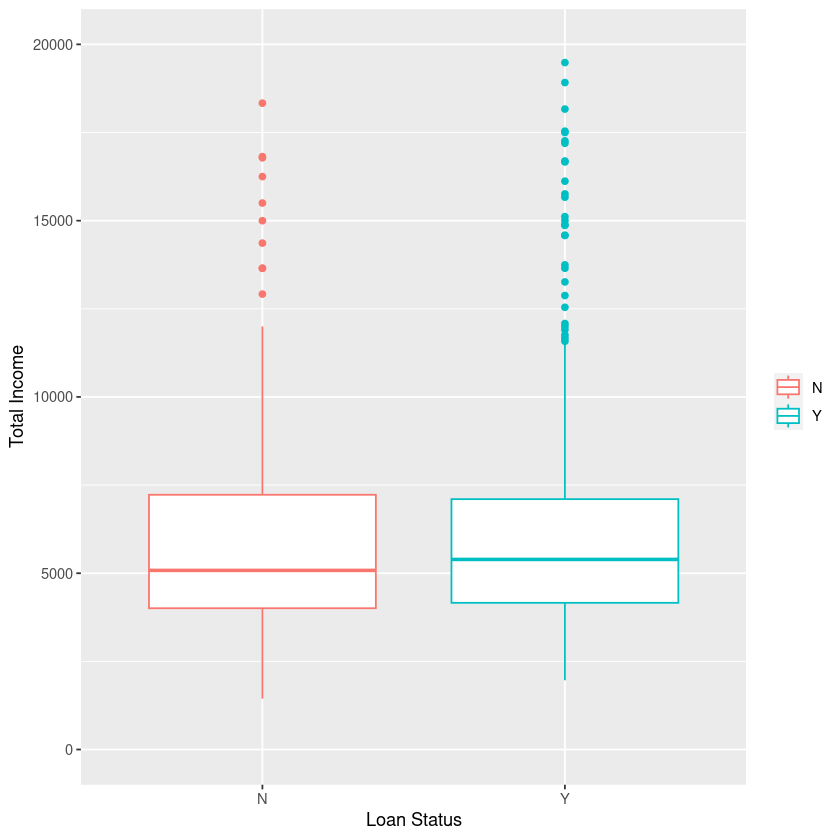

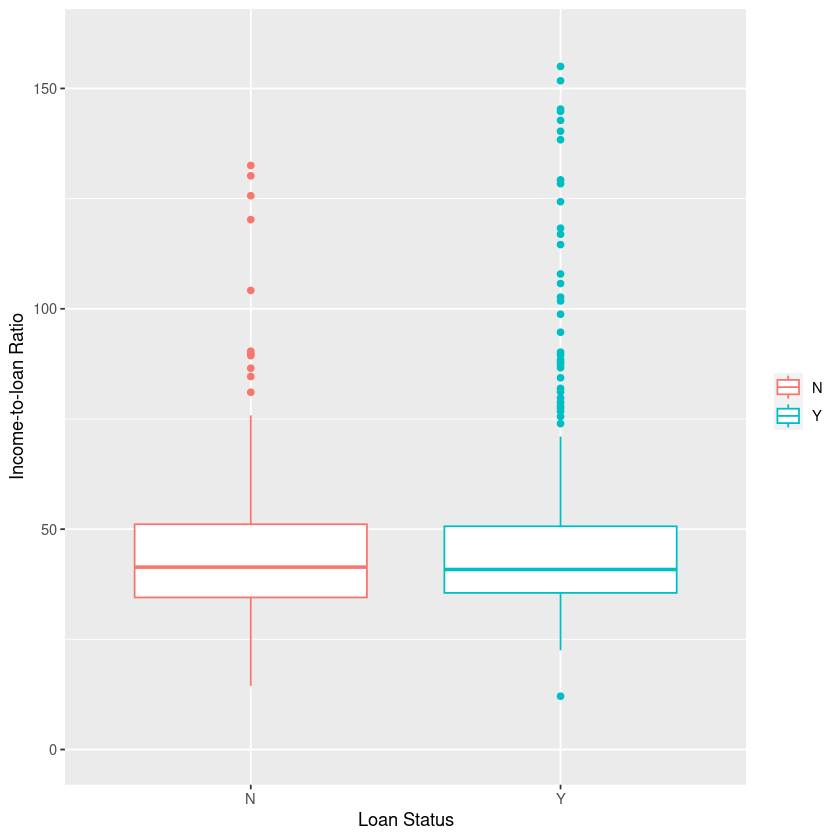

In [7]:
ggplot(train, aes(x=Loan_Status, y=total_income, color=Loan_Status)) +
  geom_boxplot() + ylim(0, 20000) + labs(y = 'Total Income', x = 'Loan Status') +
  theme(legend.title= element_blank())

ggplot(train, aes(x=Loan_Status, y=income_to_loan_ratio, color=Loan_Status)) +
  geom_boxplot() + ylim(0, 160) + labs(y = 'Income-to-loan Ratio', x = 'Loan Status') +
  theme(legend.title= element_blank())

Observation:

- Surprisingly, income variables, like total income, income-to-loan ratio do not seem to have effects on loan approval.
- Smaller loans, less than 50 units, are more likely to be approved than bigger loans.

# Modelling


Call:
 randomForest(formula = Loan_Status ~ ., data = train_imputed,      mtry = 4, ntree = 1501, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 1501
No. of variables tried at each split: 4

        OOB estimate of  error rate: 19.06%
Confusion matrix:
    N   Y class.error
N 100  92  0.47916667
Y  25 397  0.05924171

,N,Y,MeanDecreaseAccuracy,MeanDecreaseGini
Gender,-7.3126646,6.068536,1.623542,3.011399
Married,0.8273376,1.552851,1.789060,4.095041
Dependents,-4.1739871,7.587404,4.006022,9.766743
Education,-0.3153997,5.356866,4.501703,3.838311
Self_Employed,-2.9180278,5.595721,3.888658,3.043107
ApplicantIncome,-2.9828258,36.754034,34.781870,31.349695
CoapplicantIncome,-1.4103934,20.425576,19.200731,18.645154
LoanAmount,-3.4770815,23.484296,21.660261,28.356134
Loan_Amount_Term,0.1319280,14.086505,12.193477,8.194476
Credit_History,131.8778038,132.230446,152.942767,70.997824


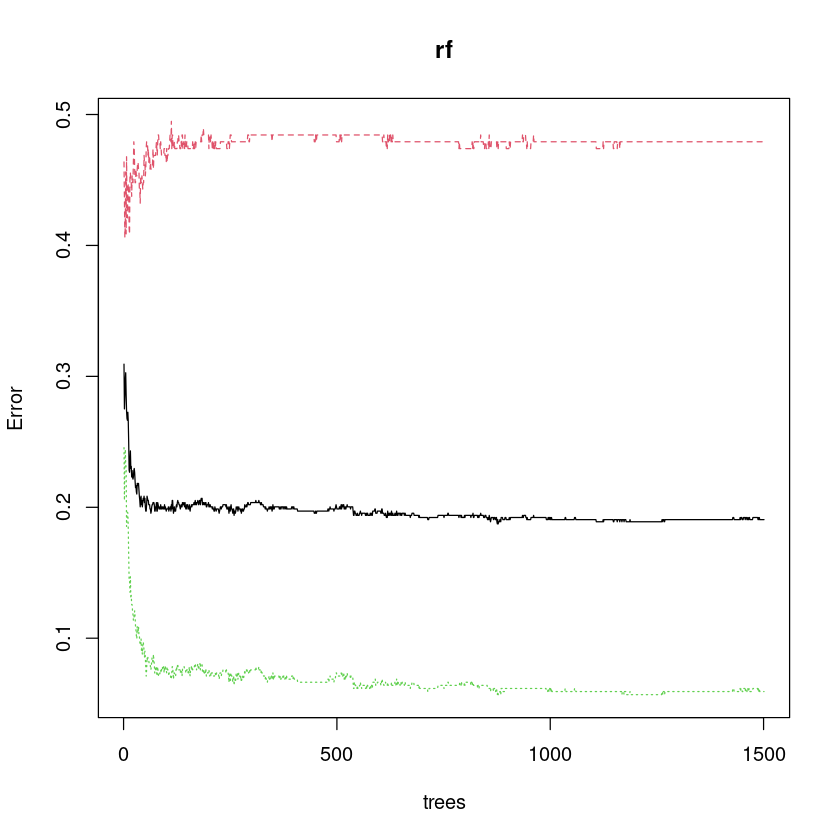

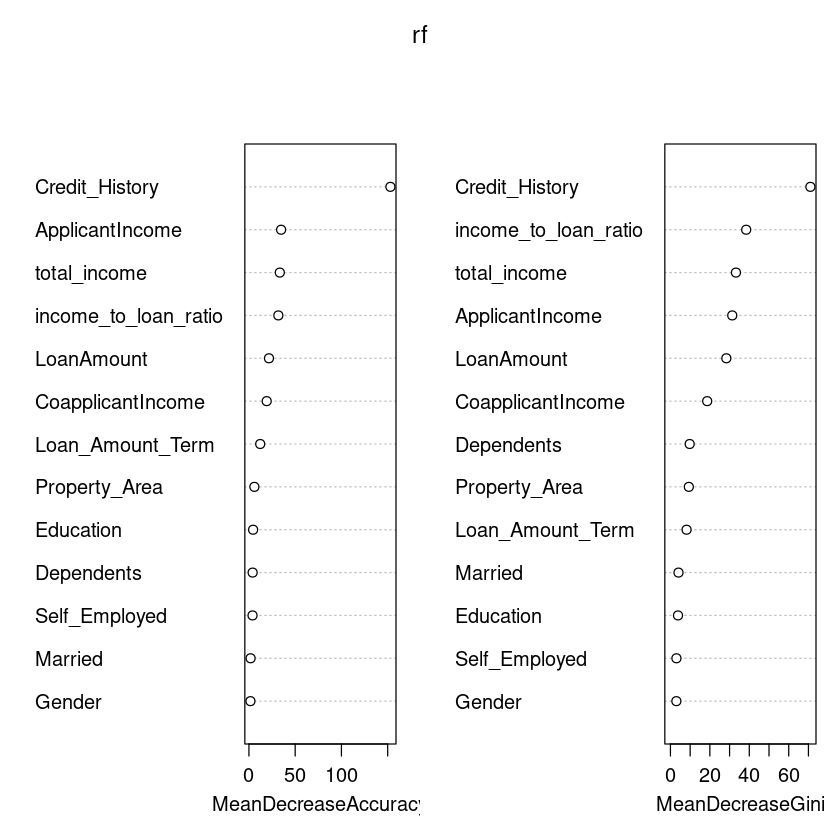

In [8]:

set.seed(100)

rf <- randomForest(Loan_Status ~ ., data = train_imputed, mtry = 4, ntree = 1501, importance = TRUE)

rf

plot(rf)

importance(rf)
varImpPlot(rf)


# Conclusion

- Credit history is the most important factor in determining loan approval.
- The rest like, total income, income-to-loan ratio have smaller effects on loan approval.
- We have prediction accuracy of 80.29 percent.
- The confusion matrix tells us that loans that are supposed to be approved are predicted as approved most of the times by our model, about 93.2 percent of the time.
- Loans that are not supposed to be approved are sometimes falsely predicted as approved by our model. This occurs about 48 percent of the times.
- Overall, the problem is that the model gives us many false positives (Loans that are not supposed to be approved are approved by our model).

# Limitations

Why is our model giving so many false-positives? The reason for this, we believe, is that we are missing some very important data, such as debt. For instance, given the data that we have now, an applicant has a very high monthly income, a good credit history, and the loan is also relatively small. Given this information and how our model is trained, this application should be approved, but in reality, it is rejected. Why is that? It is possible that the applicant has a lot of debt, say three million dollars, and that the applicant is barely covering the monthly interest payments. Obviously, it would be risky to lend someone more money when they are already in so much debt and not enough income to cover the interest and principal payments from their massive debt.

Another issue is the missing values we have in our data. There are many missing values in our data and we used imputation to impute these data. Obviously, imputation is not perfect, and the imputed data maybe not be accurate.

